In [2]:
import damask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

/home/snkrkr/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/snkrkr/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/snkrkr/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
resultfile_path = 'reference_output/tensionX_material_fullfield_10materials_6ferrite_4martensite_10grains_voronoi_5x5x5/simulation_output.hdf5'

In [4]:
result = damask.Result(resultfile_path)
try:
    result.add_stress_Cauchy()
except ValueError:
    pass
try:
    result.add_equivalent_Mises('sigma')
except ValueError:
    pass
try:
    result.add_stress_second_Piola_Kirchhoff()
except ValueError:
    pass

try:
    result.add_strain()
except ValueError:
    pass

postprossecing_dir = Path(resultfile_path).stem
vti_path = list(Path(resultfile_path).parent.glob("*.vti"))[0]
material_path = list(Path(resultfile_path).parent.glob("material*"))[0]
grid = damask.GeomGrid.load(vti_path)

with open(material_path, 'r') as f:
    material_dict = yaml.load(f)
material_grid_mapping = {}
for id, material in enumerate(material_dict['material']):
    phase = material['constituents'][0]['phase']
    if not phase in material_grid_mapping:
        material_grid_mapping[phase] = []
    material_grid_mapping[phase].append(id)
material_grid_mapping

/tmp/ipykernel_4011140/3863228441.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  material_dict = yaml.load(f)


{'Ferrite': [0, 1, 2, 3, 4, 5], 'Martensite': [6, 7, 8, 9]}

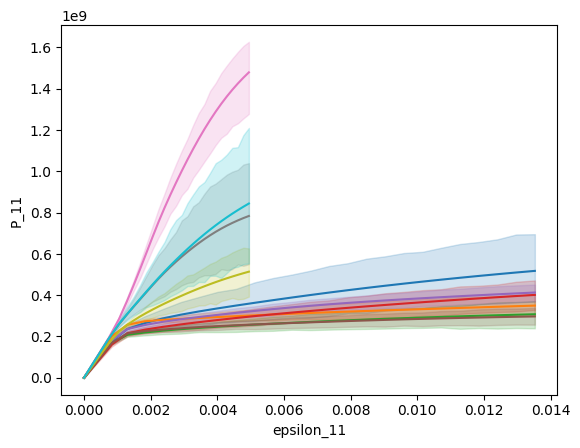

In [10]:
def plot_stress_strain_multiphase(grid, result):
    data = {}
    for phase in result.view(increments=0).get(['epsilon_V^0.0(F)','P']).keys():
        for g in material_grid_mapping[phase]:
            data[f'{phase}_{g}'] = pd.DataFrame()
    for phases in result.get(['epsilon_V^0.0(F)','P']).values():
        for phase, inc in phases.items():
            P = inc['P']
            epsilon = inc['epsilon_V^0.0(F)']
            for g in material_grid_mapping[phase]:
                material_phase = ([i for i in grid.material.flatten(order='F') if i in material_grid_mapping[phase]])
                points = np.array(material_phase) == g
                P_11 = P[points,0,0].flatten()
                epsilon_11 = np.broadcast_to(np.average(epsilon[:,0,0]),P_11.shape)
                x = pd.DataFrame({'epsilon_11':epsilon_11,'P_11':P_11})
                data[f'{phase}_{g}'] = pd.concat((data[f'{phase}_{g}'],x),ignore_index=True)
    for phase in result.view(increments=0).get(['epsilon_V^0.0(F)','P']).keys():
        for g in material_grid_mapping[phase]:
            plot = sns.lineplot(y='P_11',x='epsilon_11',data=data[f'{phase}_{g}'])
    fig = plot.get_figure()

plot_stress_strain_multiphase(grid, result)
